# Comparison of the 2-fold method and our extension

This notebook provides simulation experiments that demonstrate how the 2-fold method can have a very considerable false-positive-rate. We calculate the false-positive-rate for a wide range of scenarios. We demonstrate two things:
1. In the edge cases both methods agree. With edge cases we mean scenarios where we have a large number of subjects, a low variance, or a very poor model. This is unsurprising since our method is an extension of the 2-fold method.
2. In cases where there is simply not enough information to make a decision, our method will refrain from doing so, contrary to the 2-fold method.

### The necessary code, the experiments start below

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

In [2]:
def geomean(x):
    """Calculate the geometric mean"""
    return np.prod(x)**(1/len(x))

In [3]:
def get_acceptance_rate(*, true_ratio, CV, n_subjects, n_simulations=10000):
    """
    Get the acceptance rate when using the 2-fold method.

    Arguments:
        true_ratio: The true geometric mean ratio (e^muhat / e^mu).
        CV: The geometric coefficient of variation of the subjects.
        n_subjects: The number of subjects
        n_simulations: The number of simulations that is used to calculate the acceptance rate

    Return:
        acceptance_rate: The simulated acceptance rate.
    """
    accepted = 0
    true_gmean = 300
    simulated_gmean = true_ratio * true_gmean
    std_dev = np.sqrt(np.log(CV**2 + 1))
    ratios = []
    for i in range(n_simulations):
        observed_values = np.exp(np.random.normal(loc=np.log(true_gmean), scale=std_dev, size=n_subjects))
        ratio =  simulated_gmean / geomean(observed_values)
        ratios.append(ratio)
        if  0.5 <= ratio <= 2:
            accepted += 1
    acceptance_rate = accepted / n_simulations
    return acceptance_rate

In [4]:
def CI_method(GM_observed, GM_predicted, GCV, N, alpha=0.1):
    """This function calculates a confidence interval using the observed
       geometric mean, the predicted geometric mean, and the coefficient
       of variation.

    Arguments:
      GM_observed (float): The geometric mean of the observations
      GM_predicted (float): The geometric mean of the predictions
      GCV (float): The geometric coefficient of variation. Note that values are
        often reported as percentiles in literature. If 70% is reported, use 0.7.
      N (int): The number of observations.
      alpha (float): Determines the significance of the confidence interval.
        The significance is (1-alpha/2)*100%.

    Return:
      The result of the test (reject (0), accept (1), refrain (2))
    """
    average = np.log(GM_observed)
    var = np.log(GCV**2 + 1)
    t = scipy.stats.t(N-1).ppf(1-alpha/2)
    loglowerbound = average + t * np.sqrt(var / N)
    logupperbound = average - t * np.sqrt(var / N)
    CI = [GM_predicted / np.exp(loglowerbound), GM_predicted / np.exp(logupperbound)]
    if CI[1] < 0.5:
        return 0  # Reject
    if CI[0] < 0.5 and CI[1] > 0.5:
        return 2  # Refrain
    if CI[0] > 0.5 and CI[1] < 2:
        return 1  # Accept
    if CI[0] < 2 and CI[1] > 2:
        return 2  # Refrain
    if CI[0] > 2:
        return 0  # Accept

In [5]:
def simulate_CI_method(*, true_ratio, CV, n_subjects, n_simulations=10000):
    """Compute the results of a large number of simulated subjects using the CI method."""
    results = np.zeros(n_simulations)
    true_gmean = 300  # Results are the same for any true_gmean since we work with the coefficient of variation.
    simulated_gmean = true_ratio * true_gmean
    std_dev = np.sqrt(np.log(CV**2 + 1))
    ratios = []
    for i in range(n_simulations):
        observed_values = np.exp(np.random.normal(loc=np.log(true_gmean), scale=std_dev, size=n_subjects))
        observed_geometric_mean = geomean(observed_values)
        GCV = np.sqrt(np.exp(np.var(np.log(observed_values))) - 1)
        results[i] = CI_method(observed_geometric_mean, simulated_gmean, GCV=GCV, N=n_subjects)
    return results

## Problems with the 2-fold method

The 2-fold method can easily result in a very high false positive rate when we use a small number of subjects. The actual false-positive-rate depends on the variance of the subjects and on the quality of the model. If the true GMR ($e^{\hat{\mu}} / e^{\mu}$) is slightly below 0.5 or above 2, the false-positive-rate will be higher.

We first consider a setting where the true GMR is 0.45 and we have five subjects with a CV of 0.8. We simulate 10.000 sets of 5 patients and calculate how often we would have accepted the model even though we should have rejected it.

In [14]:
accepted = 0
actual_ratio = 0.45  # Actual geometric mean ratio.
true_gmean = 300 # Results only depend on CV, any value for true_gmean gives the same results.
simulated_gmean = actual_ratio * true_gmean
CV = 0.8
std_dev = np.sqrt(np.log(CV**2 + 1))
ratios = []
n_simulations = 10000
n_subjects = 5
for i in range(n_simulations):
    observed_values = np.exp(np.random.normal(loc=np.log(true_gmean), scale=std_dev, size=n_subjects))
    ratio =  simulated_gmean / geomean(observed_values)
    ratios.append(ratio)
    if  0.5 <= ratio <= 2:
        accepted += 1
FPR = accepted / n_simulations
print(f'FPR = {FPR}')

FPR = 0.3708


The histogram below illustrates what is going on. The observed GMR is a random variable since it depends on the random observations. This can lead us to have an acceptable GMR by chance.

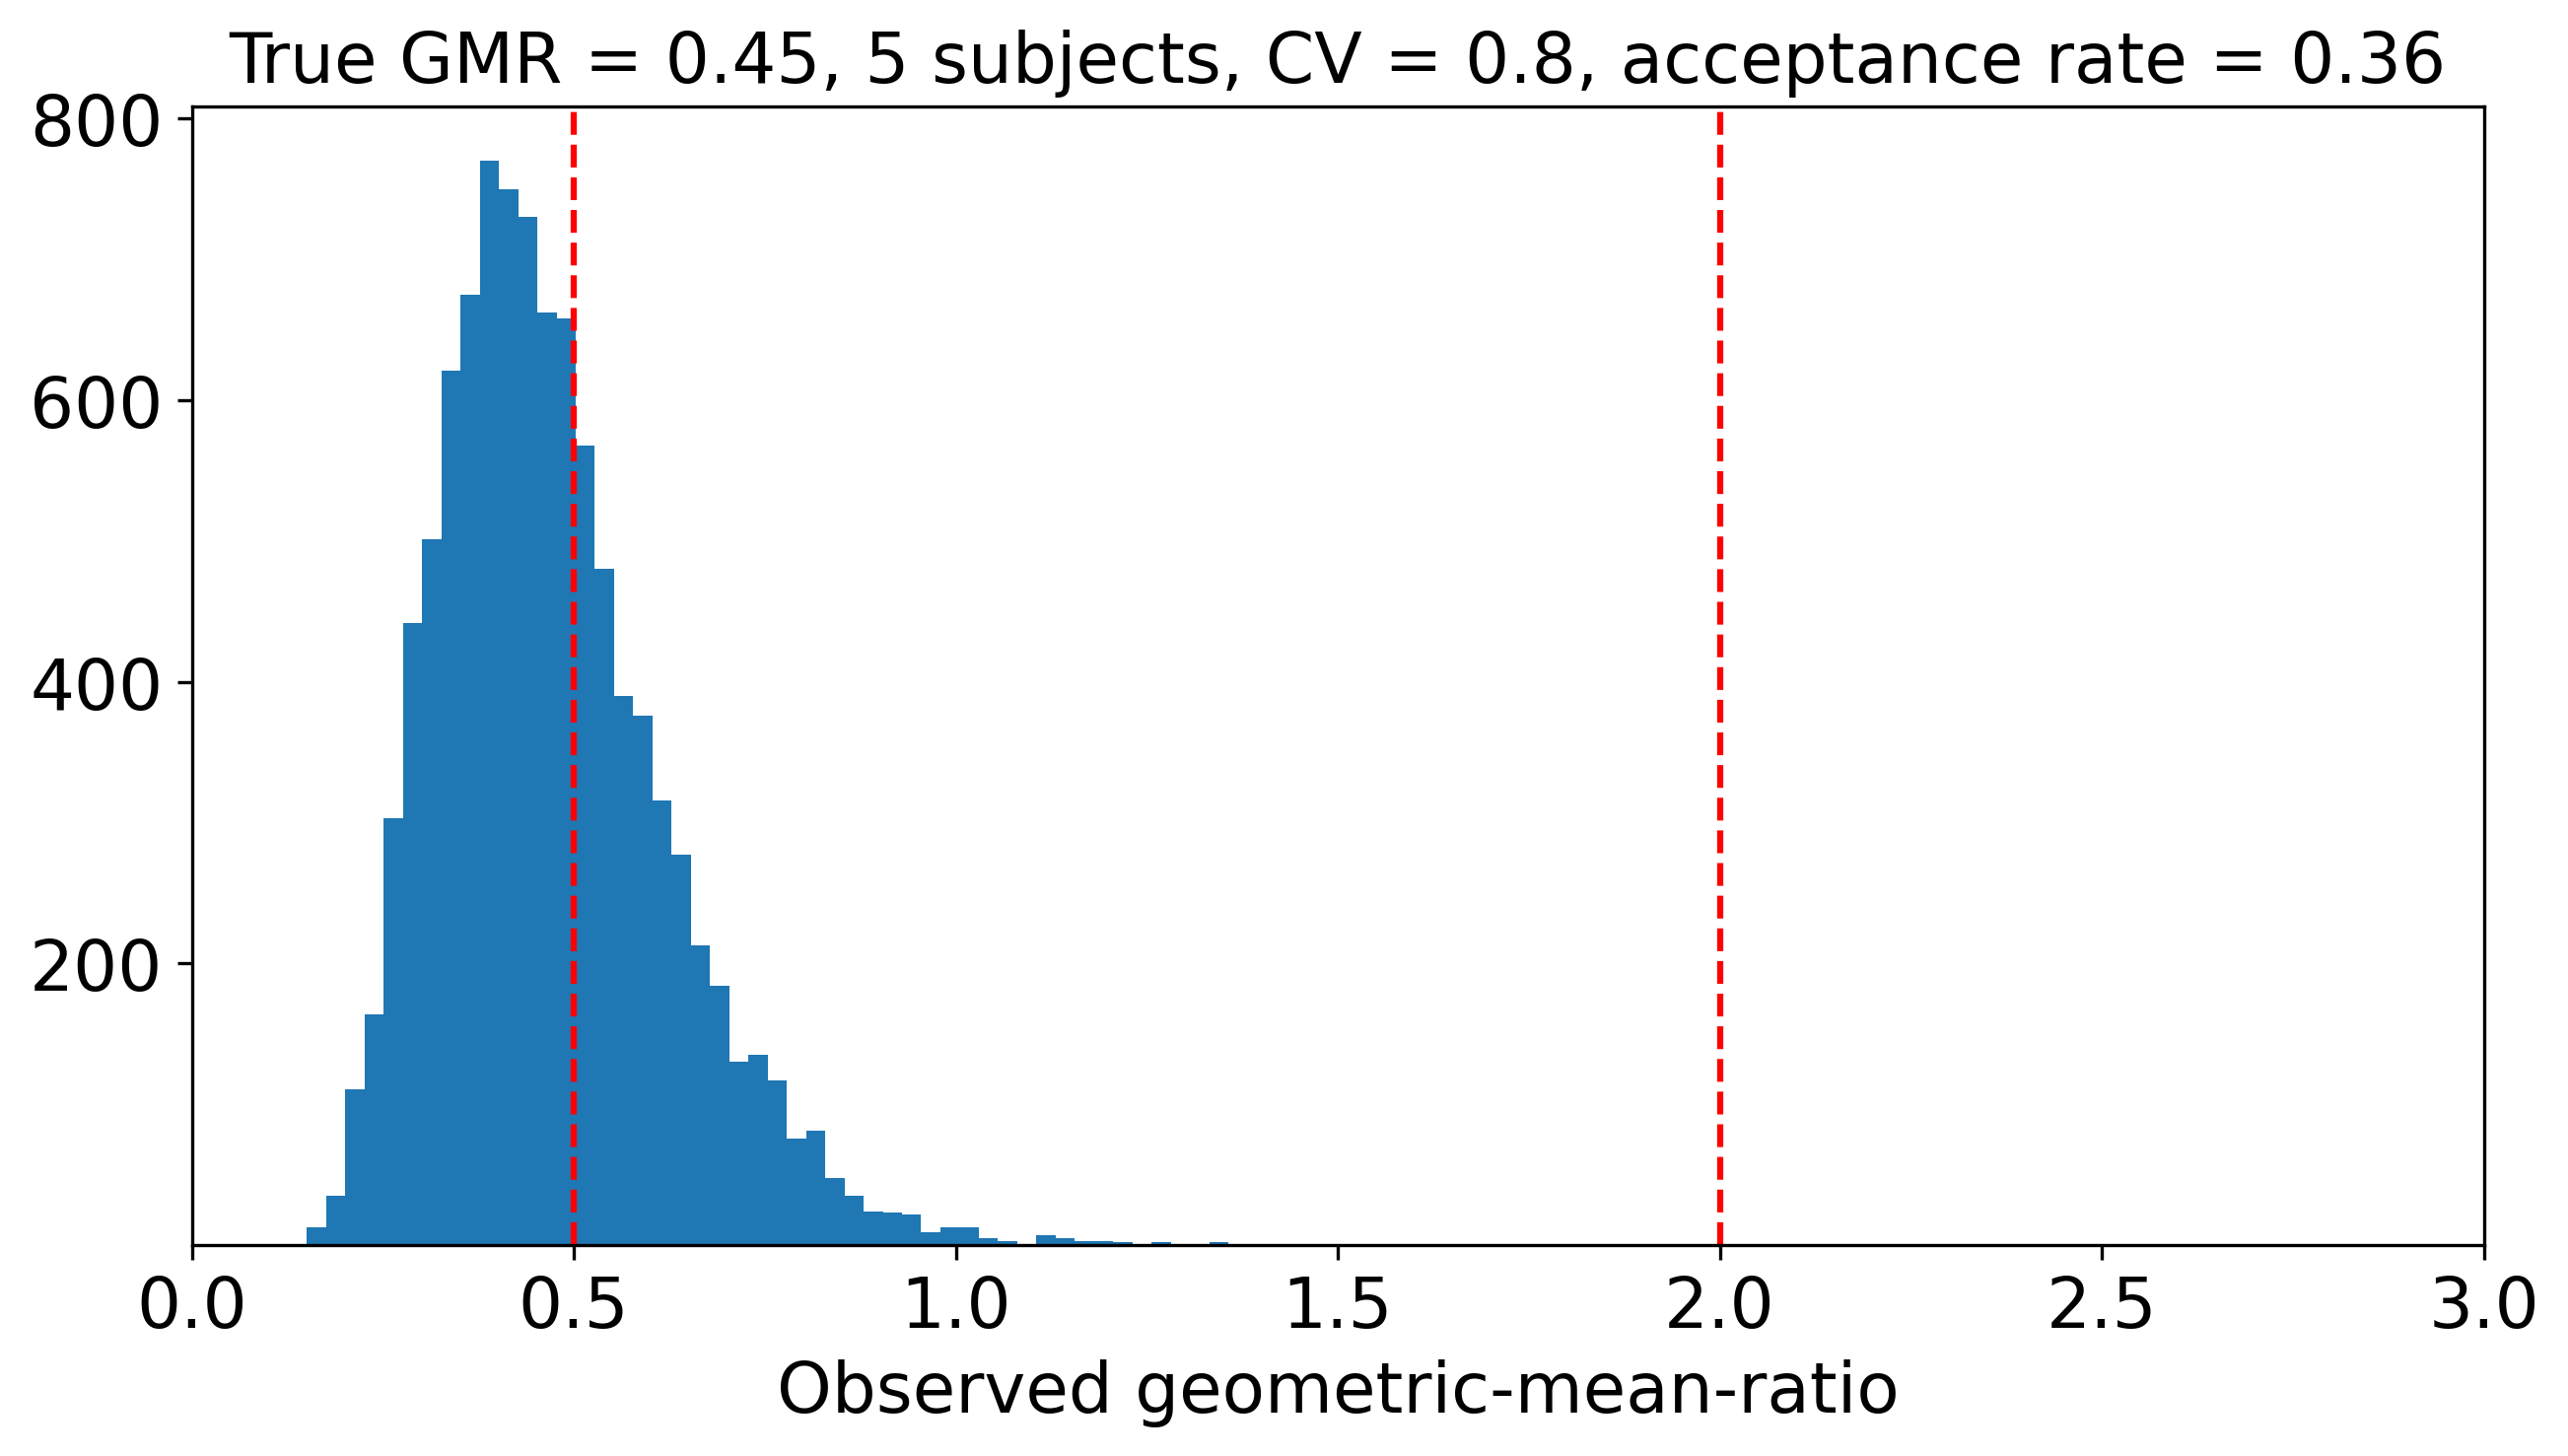

In [11]:
fontsize = 17
plt.figure(dpi=300, figsize=(10, 5))
plt.hist(ratios, bins=np.linspace(0, 5, 200))
plt.xlim((0, 3))
plt.axvline(x=0.5, color='red', linestyle='--')
plt.yticks([200, 400, 600, 800], fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.axvline(x=2, color='red', linestyle='--')
plt.xlabel('Observed geometric-mean-ratio', fontsize=fontsize)
plt.title(f'True GMR = {np.round(actual_ratio, 2)}, {n_subjects} subjects, CV = {CV}, acceptance rate = {np.round(FPR,2)}', fontsize=fontsize)
plt.show()

We extend this experiment by evaluating the false-positive-rate for a number of different combinations of true GMRs, CVs, and number of subjects. The tables below give the results where the columns correspond to different numbers of simulated subjects and the row to different CVs.

In [17]:
true_ratios = [0.7, 0.49, 0.45, 0.4, 0.3]
CVs = [0.8, 0.7, 0.6, 0.5]
ns_subjects = [5, 10, 15, 20]
data_frames = {}
for ratio in true_ratios:
    data = []
    for CV in CVs:
        row_data = []
        for n in ns_subjects:
            acceptance_rate = get_acceptance_rate(true_ratio=ratio, CV=CV, n_subjects=n)
            row_data.append(acceptance_rate)
        data.append(row_data)
    df = pd.DataFrame(data, index=CVs, columns=ns_subjects)
    data_frames[ratio] = df

In [85]:
for ratio in true_ratios:
    print(f'True ratio: {ratio}')
    print('CV           number of subjects         ')
    print(f'{data_frames[ratio]}')
    print('-----------------')

True ratio: 0.7
CV           number of subjects         
         5       10      15      20
0.8  0.8611  0.9316  0.9696  0.9836
0.7  0.8829  0.9585  0.9793  0.9914
0.6  0.9123  0.9739  0.9899  0.9954
0.5  0.9423  0.9874  0.9977  0.9987
-----------------
True ratio: 0.49
CV           number of subjects         
         5       10      15      20
0.8  0.4720  0.4696  0.4506  0.4530
0.7  0.4709  0.4636  0.4530  0.4454
0.6  0.4724  0.4556  0.4434  0.4375
0.5  0.4642  0.4493  0.4321  0.4251
-----------------
True ratio: 0.45
CV           number of subjects         
         5       10      15      20
0.8  0.3619  0.3206  0.2870  0.2500
0.7  0.3558  0.3017  0.2516  0.2260
0.6  0.3387  0.2769  0.2358  0.1938
0.5  0.3078  0.2417  0.1928  0.1610
-----------------
True ratio: 0.4
CV           number of subjects         
         5       10      15      20
0.8  0.2356  0.1592  0.1036  0.0771
0.7  0.2085  0.1326  0.0806  0.0607
0.6  0.1931  0.1023  0.0580  0.0384
0.5  0.1472  0.0667  0.0339  0.0

## How does our method deal with a bad model?

In the previous example, we saw that the 2-fold method can have a considerable false-positive-rate. The following example illustrates how our method prevents this. If the model is bad, a true GMR of 0.3, and we have a large number of subjects and low variance (20 and 0.5 respectively), our method comes to the same conclusion as the 2-fold method. This is unsurprising since our method is an extension of the 2-fold method.

In [20]:
results = simulate_CI_method(true_ratio=0.3, CV=0.5, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.999
accept: 0.0
refrain: 0.001


In [90]:
results = simulate_CI_method(true_ratio=0.3, CV=0.8, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.9376
accept: 0.0
refrain: 0.0624


In the case, however, where there is not enough evidence to make decision, our method will refrain from doing so. In the below example, we have a model that is close to the acceptable region (a true GMR of 0.45), where the five subjects are simulated from a lognormal distribution with a high CV of 0.8. Our method refrains from making a decision in 86% of simulations.

In [44]:
results = simulate_CI_method(true_ratio=0.45, CV=0.8, n_subjects=5)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.1106
accept: 0.031
refrain: 0.8584


## What happens if the model is good?

We now test a scenario where we have 15 subjects, a good model (the true GMR is 1.2), and a relatively high CV of 0.8. We see that we accept the model in 86% of simulations and refrain from making a decision in 14% of simulations.

In [41]:
results = simulate_CI_method(true_ratio=1.2, CV=0.8, n_subjects=15)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.8631
refrain: 0.1369


If we have a lower CV, of 0.5, we accept the model 99% of the time.

In [42]:
results = simulate_CI_method(true_ratio=1.2, CV=0.5, n_subjects=15)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.9921
refrain: 0.0079


Similarly, if we have a high CV (0.8), but a larger amount of subjects (30), we also accept the model 99% of the time.

In [80]:
results = simulate_CI_method(true_ratio=1.2, CV=0.8, n_subjects=30)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.9874
refrain: 0.0126


Various other scenarios

In [91]:
results = simulate_CI_method(true_ratio=0.7, CV=0.8, n_subjects=5)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.008
accept: 0.2224
refrain: 0.7696


In [92]:
results = simulate_CI_method(true_ratio=0.7, CV=0.8, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0001
accept: 0.6681
refrain: 0.3318


In [93]:
results = simulate_CI_method(true_ratio=0.7, CV=0.5, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.0
accept: 0.9312
refrain: 0.0688


In [95]:
results = simulate_CI_method(true_ratio=0.45, CV=0.5, n_subjects=20)
print(f'reject: {np.mean(results == 0)}')
print(f'accept: {np.mean(results == 1)}')
print(f'refrain: {np.mean(results == 2)}')

reject: 0.2608
accept: 0.0053
refrain: 0.7339


## Conclusion

We saw in this notebook that our method really is an extension of the 2-fold method. When we have a large number of subjects or a low variance, both methods will come to the same conclusion. If, however, we do not have a large number of subjects, a high variance, or our model's performance is close to the acceptable boundaries, we see the advantage of our extension. Where the 2-fold approach will always make a choice to accept or reject the model, sometimes with a very non-negligible falls-positive-rate, our method will generally refrain from making a decision, indicating that there is not enough evidence to either accept or reject the model